### Singlephotoelectron mini analysis: windows identification

The plugIn for getting the LED data can be find here: https://github.com/XENONnT/straxen/blob/led_plugin/straxen/plugins/led_calibration.py.

The motivation for this analysis is to estimate the SPE acceptance using low-intensity LED runs.

Before using the plugin, the LED windwos and the noise window have to be indentificated.

In [1]:
%run '/home/gvolta/XENONnT/LedAnalysis/Initialization_for_SPE.py'

0.0.8
               option          default    current          applies_to  \
0          LED_window       (125, 250)  <OMITTED>  (led_calibration,)   
1        noise_window       (350, 475)  <OMITTED>  (led_calibration,)   
2         light_level         (0, 248)  <OMITTED>  (led_calibration,)   
3         pax_raw_dir  /data/xenon/raw  <OMITTED>      (raw_records,)   
4     stop_after_zips                0  <OMITTED>      (raw_records,)   
5    events_per_chunk               50  <OMITTED>      (raw_records,)   
6  samples_per_record              110  <OMITTED>      (raw_records,)   

                                                help  
0  Window (samples) where we expect the signal in...  
1             Window (samples) to analysis the noise  
2  Three different light level for XENON1T: (0,36...  
3                    Directory with raw pax datasets  
4         Convert only this many zip files. 0 = all.  
5                Number of events to yield per chunk  
6                       

In [2]:
runs = st.select_runs(run_mode='LED*')

Checking data availability: 100%|██████████| 5/5 [00:27<00:00,  5.79s/it]


#### Determining LED and noise window:
- Identify the rough amplitude range corresponding to a single photoelectron;
- Find the time window in which we have an excess of sample in this amplitude range;
- Define the noise window far from the LED window.

In [3]:
run_id = '180219_1049'
data_rr = st.get_array(run_id, 'raw_records', seconds_range=(0,20))

In [4]:
datatype = [('pmt', np.int16),
            ('Amplitude', np.float32),
            ('Sample of Amplitude', np.float32)]

Data = np.zeros((len(data_rr)), dtype = datatype)

for i in range(len(data_rr)):
    Data[i]['pmt'] = data_rr['channel'][i]
    Data[i]['Amplitude'] = np.max(data_rr['data'][i])
    Data[i]['Sample of Amplitude'] = np.argmax(data_rr['data'][i])

In [5]:
window, info, df2 = SPErough(data = Data)

  0%|          | 1/248 [00:00<00:44,  5.53it/s]/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/scipy/optimize/minpack.py:733: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.6/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 248/248 [00:09<00:00, 26.14it/s]


Start 25: 2018-02-19 10:50:00.034530130
Start 151: 2018-02-19 10:50:00.024699790


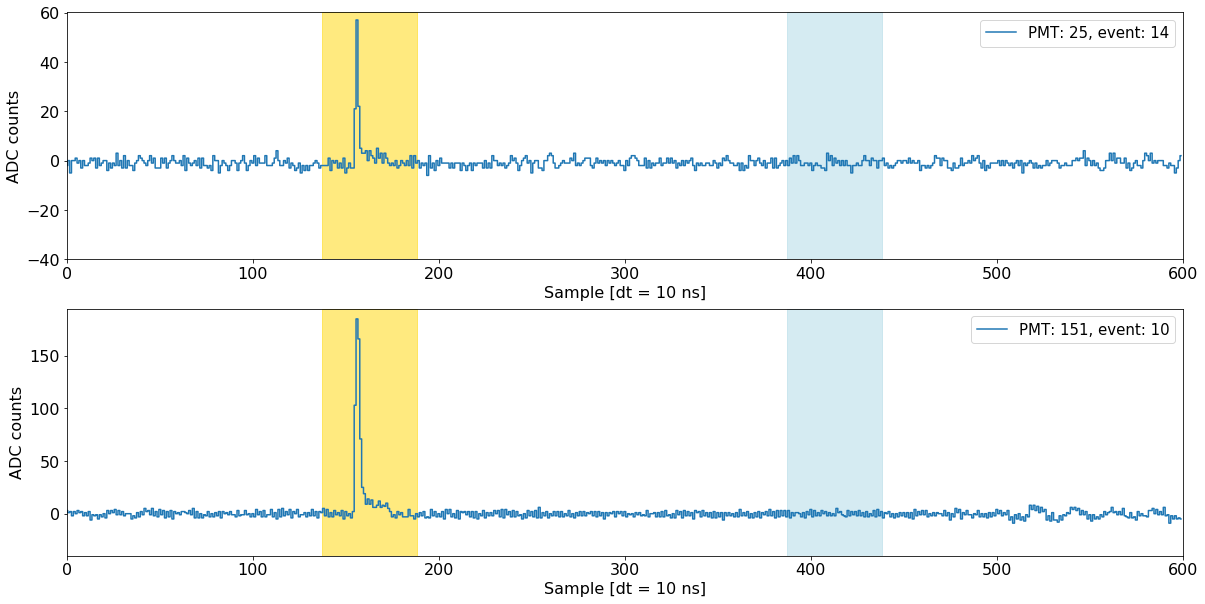

In [6]:
plt.figure(figsize=(20,10))
###################################################################
PMT_n = data_rr[data_rr['channel']==25]
plt.subplot(211)
event = 14
plot_peak(PMT_n[event], label = 'PMT: ' + str(PMT_n[event]['channel']) + ', event: ' + str(event))
plt.axvspan(window[0], window[1], alpha=0.5, color='gold')
plt.axvspan(window[0]+250, window[1]+250, alpha=0.5, color='lightblue')
plt.legend(loc='best', fontsize=15)
plt.ylim(bottom = -40)
plt.xlim(0, 600)
###################################################################
PMT_n = data_rr[data_rr['channel']==151]
plt.subplot(212)
event = 10
plot_peak(PMT_n[event], label = 'PMT: ' + str(PMT_n[event]['channel']) + ', event: ' + str(event))
plt.axvspan(window[0], window[1], alpha=0.5, color='gold')
plt.axvspan(window[0]+250, window[1]+250, alpha=0.5, color='lightblue')
plt.legend(loc='best', fontsize=15)
plt.ylim(bottom = -40)
plt.xlim(0, 600)
###################################################################
plt.show()

### SPE accepante
- Evan's note: https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:saldanha:xe1t:single_photoelectron_amplitude

In [7]:
st_2 = st.new_context(config=dict(LED_window=(window[0],window[1]), noise_window=(window[0]+250, window[1]+250)))
st_2.show_config('led_calibration')

,option,default,current,applies_to,help
0,LED_window,"(125, 250)","(137, 188)","(led_calibration,)",Window (samples) where we expect the signal in LED calibration
1,noise_window,"(350, 475)","(387, 438)","(led_calibration,)",Window (samples) to analysis the noise
2,light_level,"(0, 248)",<OMITTED>,"(led_calibration,)","Three different light level for XENON1T: (0,36), (37,126), (127,248). Defalt value: all the PMTs"
3,pax_raw_dir,/data/xenon/raw,<OMITTED>,"(raw_records,)",Directory with raw pax datasets
4,stop_after_zips,0,<OMITTED>,"(raw_records,)",Convert only this many zip files. 0 = all.
5,events_per_chunk,50,<OMITTED>,"(raw_records,)",Number of events to yield per chunk
6,samples_per_record,110,<OMITTED>,"(raw_records,)",Number of samples per record


In [8]:
run_id = '180219_1049'
data_SPE = st_2.get_array(run_id, 'led_calibration')

**Scale down the off-time amplitude spectrum such that the total counts below the ADC_correction count threshold is the same as in the LED spectrum.**

**For the final acceptance values we have varied the threshold ACD counts between 3 and 7 ADC counts to study the systematic effect this has on the result.**

In [9]:
SPE = ScalingSpectrum(data = data_SPE)

100%|██████████| 249/249 [01:51<00:00,  2.23it/s]


**The acceptance as a function of amplitude (threshold) is defined as the fraction of noise-subtracted single photoelectron spectrum above that amplitude.**

In [10]:
SPE_acceptance = SPE_Acceptance(data = SPE)

100%|██████████| 249/249 [00:00<00:00, 3749.65it/s]


### SPE accepante: data visualization

In [22]:
top_pos_x = []
top_pos_y = []
bot_pos_x = []
bot_pos_y = []
acc_top = []
thr_top = []
acc_bot = []
thr_bot = []
bin_correction = 3
for i in range(0,127):
        top_pos_x.append(PMT_positions[i]['x'])
        top_pos_y.append(PMT_positions[i]['y'])
        acc_top.append(SPE_acceptance[i]['Acceptance @ 15 ADC '+str(bin_correction)+' bin']*100)
        thr_top.append(SPE_acceptance[i]['Threshold for 0.9 acceptance '+str(bin_correction)+' bin'])
for i in range(127,248):
        bot_pos_x.append(PMT_positions[i]['x'])
        bot_pos_y.append(PMT_positions[i]['y'])
        acc_bot.append(SPE_acceptance[i]['Acceptance @ 15 ADC '+str(bin_correction)+' bin']*100)
        thr_bot.append(SPE_acceptance[i]['Threshold for 0.9 acceptance '+str(bin_correction)+' bin'])

#################################################
############### Bin Correction: 3 ###############
#################################################


(-52.690000000000005,
 52.690000000000005,
 -53.24317447572439,
 53.24317447572439)

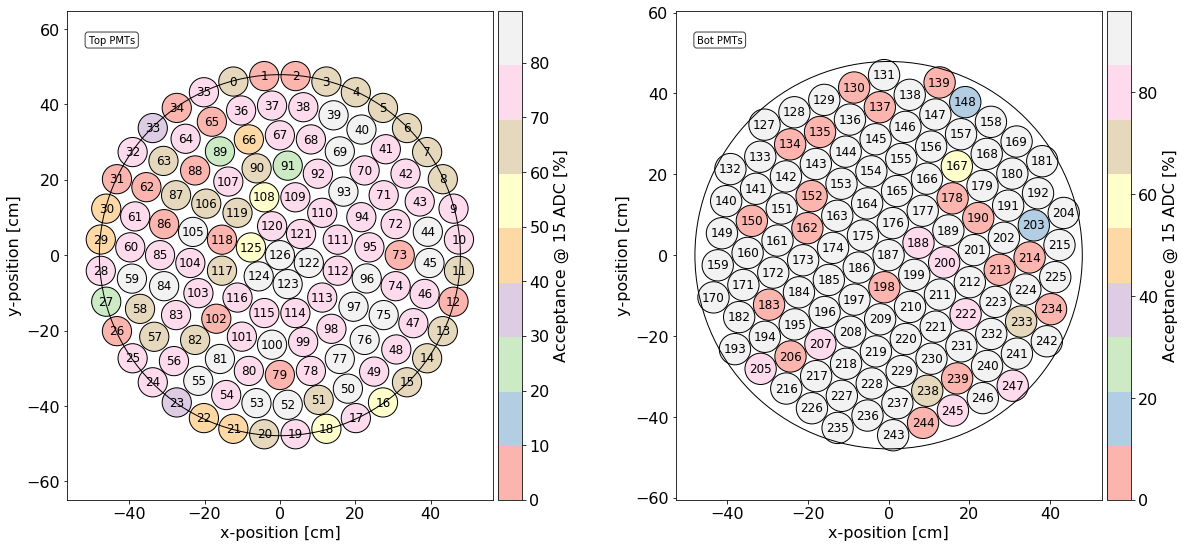

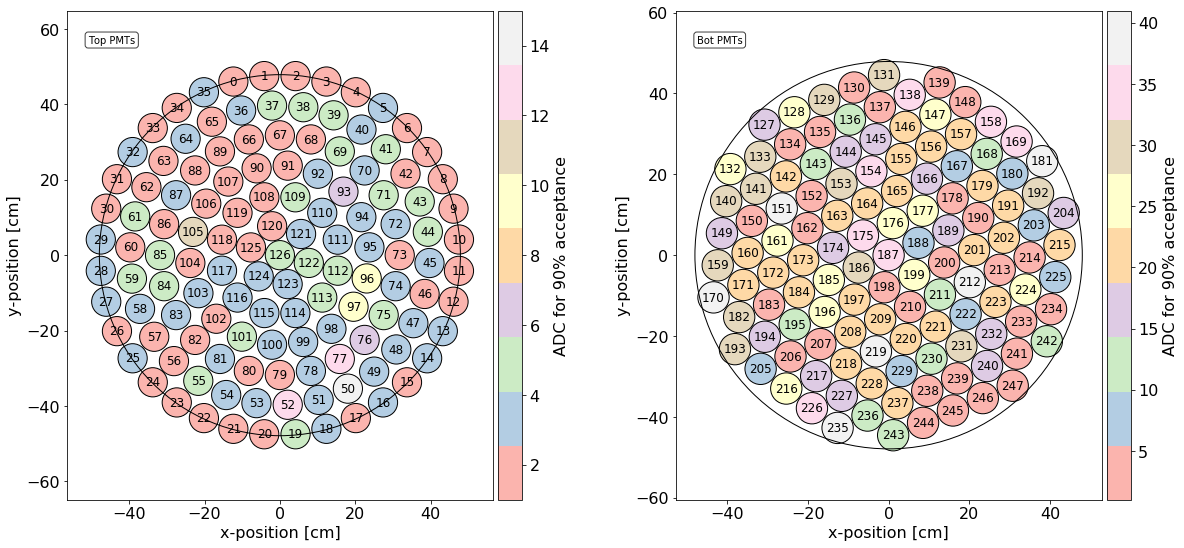

In [23]:
################################# Looking for the the SPE acceptance at 15 ADC as threshold #################################

print('#################################################')
print('############### Bin Correction: '+str(bin_correction)+' ###############')
print('#################################################')

fig = plt.figure(figsize=(20,9))
###################################################################
plt.subplot(121)

#questo fa solo il disegnino dei PMT
patches = []
for ch in range(0, len(acc_top)):
    circle = Circle((top_pos_x[ch],top_pos_y[ch]), 3.875)
    patches.append(circle)
    plt.annotate(str(ch), xy=(top_pos_x[ch],top_pos_y[ch]), fontsize=12, ha='center', va='center')
    
p = PatchCollection(patches, cmap='Pastel1', alpha=1.0, edgecolor='black') # facecolor='none'
p.set_array(np.array(acc_top))
#qui plotta la luce che vedono
p.set_clim([min(acc_top),max(acc_top)])

ax = plt.gca()
ax.add_collection(p)
ax.add_collection(PatchCollection([Circle((0,0), 47.9)], 
                                  facecolor='none', edgecolor='black', alpha=1.0))
plt.colorbar(p, ax=ax, pad=0.01, label="Acceptance @ 15 ADC [%]")
ax.text(0.05, 0.95, "Top PMTs", transform=ax.transAxes, horizontalalignment='left',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

plt.xlabel('x-position [cm]')
plt.ylabel('y-position [cm]')
plt.axis('equal')
###################################################################

###################################################################
plt.subplot(122)

patches = []
for ch in range(0, len(acc_bot)):
    circle = Circle((bot_pos_x[ch],bot_pos_y[ch]), 3.875)
    patches.append(circle)
    plt.annotate(str(ch+127), xy=(bot_pos_x[ch],bot_pos_y[ch]), fontsize=12, ha='center', va='center')
    
p = PatchCollection(patches, cmap='Pastel1', alpha=1.0, edgecolor='black') # facecolor='none'
p.set_array(np.array(acc_bot))
p.set_clim([min(acc_bot),max(acc_bot)])

ax = plt.gca()
ax.add_collection(p)
ax.add_collection(PatchCollection([Circle((0,0), 47.9)], 
                                  facecolor='none', edgecolor='black', alpha=1.0))
plt.colorbar(p, ax=ax, pad=0.01, label="Acceptance @ 15 ADC [%]")
ax.text(0.05, 0.95, "Bot PMTs", transform=ax.transAxes, horizontalalignment='left',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

plt.xlabel('x-position [cm]')
plt.ylabel('y-position [cm]')
plt.axis('equal')
###################################################################

############################### Looking for the threshold such that the SPE acceptance is 90% ###############################

fig = plt.figure(figsize=(20,9))
###################################################################
plt.subplot(121)

#questo fa solo il disegnino dei PMT
patches = []
for ch in range(0, len(thr_top)):
    circle = Circle((top_pos_x[ch],top_pos_y[ch]), 3.875)
    patches.append(circle)
    plt.annotate(str(ch), xy=(top_pos_x[ch],top_pos_y[ch]), fontsize=12, ha='center', va='center')
    
p = PatchCollection(patches, cmap='Pastel1', alpha=1.0, edgecolor='black') # facecolor='none'
p.set_array(np.array(thr_top))
#qui plotta la luce che vedono
p.set_clim([min(thr_top),max(thr_top)])

ax = plt.gca()
ax.add_collection(p)
ax.add_collection(PatchCollection([Circle((0,0), 47.9)], 
                                  facecolor='none', edgecolor='black', alpha=1.0))
plt.colorbar(p, ax=ax, pad=0.01, label="ADC for 90% acceptance")
ax.text(0.05, 0.95, "Top PMTs", transform=ax.transAxes, horizontalalignment='left',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

plt.xlabel('x-position [cm]')
plt.ylabel('y-position [cm]')
plt.axis('equal')
###################################################################

###################################################################
plt.subplot(122)

patches = []
for ch in range(0, len(thr_bot)):
    circle = Circle((bot_pos_x[ch],bot_pos_y[ch]), 3.875)
    patches.append(circle)
    plt.annotate(str(ch+127), xy=(bot_pos_x[ch],bot_pos_y[ch]), fontsize=12, ha='center', va='center')
    
p = PatchCollection(patches, cmap='Pastel1', alpha=1.0, edgecolor='black') # facecolor='none'
p.set_array(np.array(thr_bot))
p.set_clim([min(thr_bot),max(thr_bot)])

ax = plt.gca()
ax.add_collection(p)
ax.add_collection(PatchCollection([Circle((0,0), 47.9)], 
                                  facecolor='none', edgecolor='black', alpha=1.0))
plt.colorbar(p, ax=ax, pad=0.01, label="ADC for 90% acceptance")
ax.text(0.05, 0.95, "Bot PMTs", transform=ax.transAxes, horizontalalignment='left',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

plt.xlabel('x-position [cm]')
plt.ylabel('y-position [cm]')
plt.axis('equal')
###################################################################

#################################################
############### Bin Correction: 3 ###############
#################################################


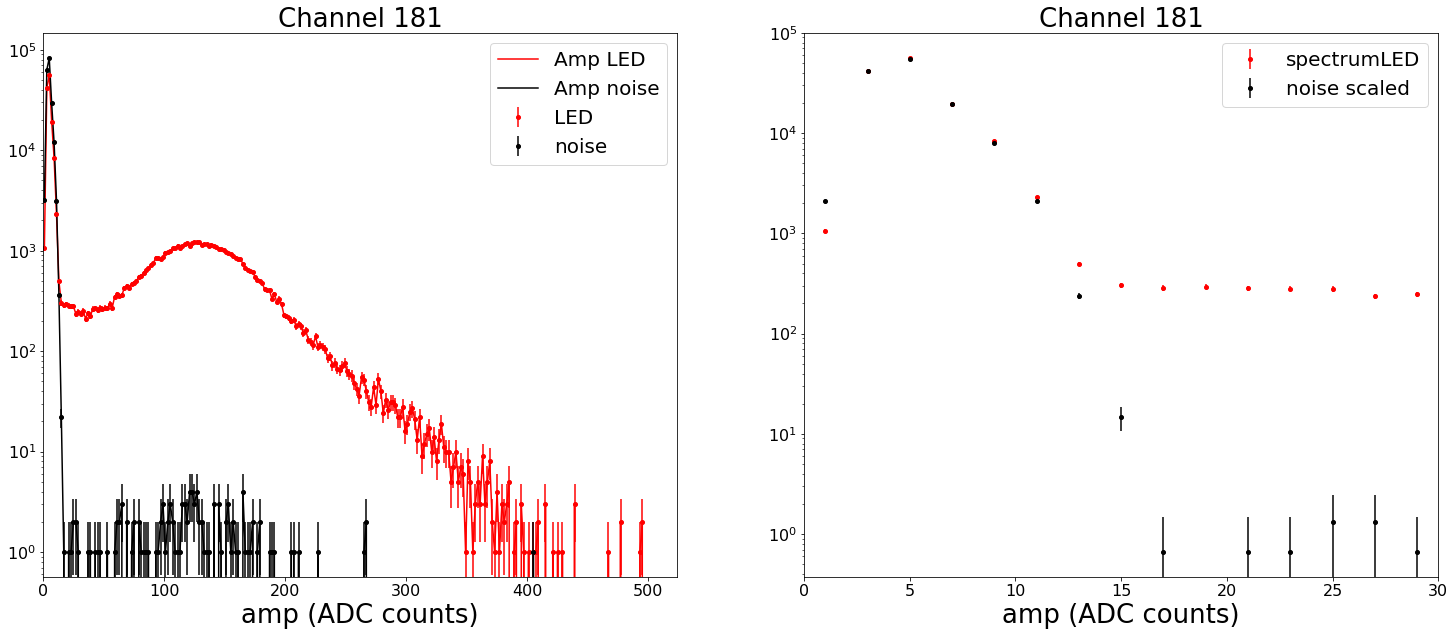

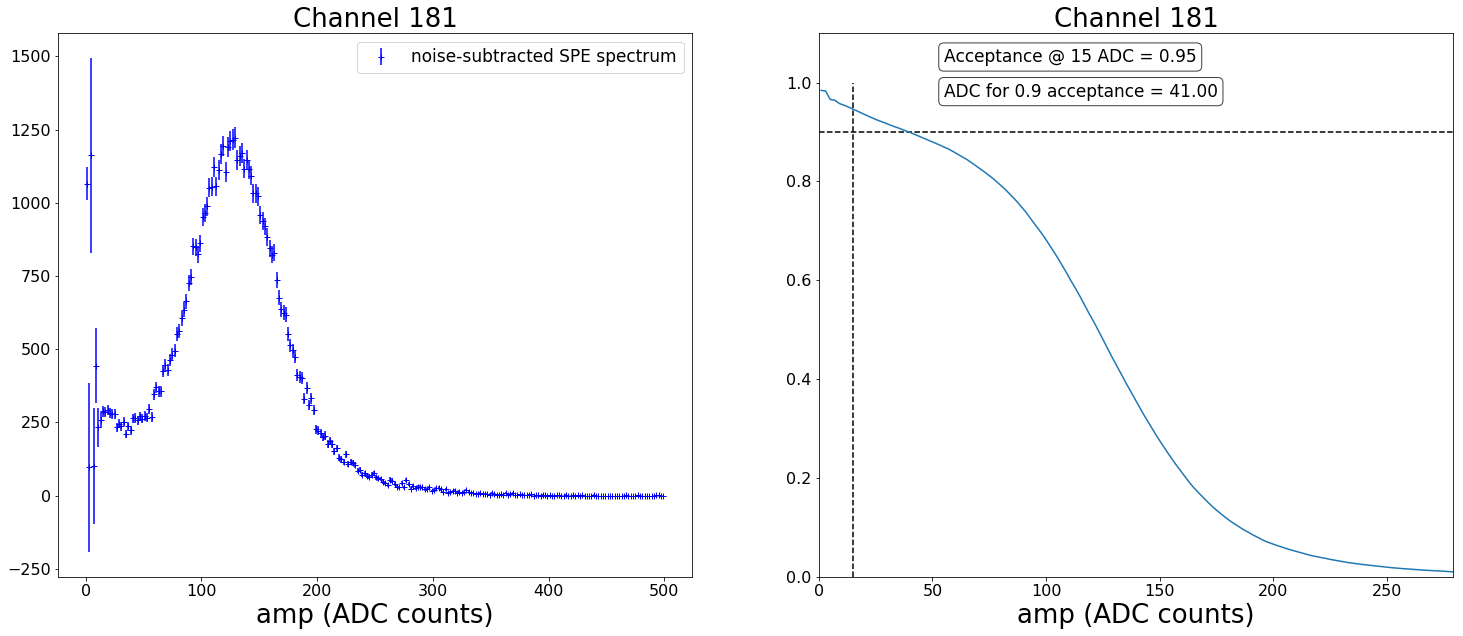

In [24]:
print('#################################################')
print('############### Bin Correction: '+str(bin_correction)+' ###############')
print('#################################################')

fig = plt.figure(figsize=(25,10))
n_channel = 181
mask = np.where(SPE_acceptance[SPE_acceptance['pmt']==n_channel]['SPE acceptance '+str(bin_correction)+' bin'][0]<0.01)
x_max = SPE_acceptance[SPE_acceptance['pmt']==n_channel]['bins SPE acceptance '+str(bin_correction)+' bin'][0][mask][0]

plt.subplot(121)

plt.plot(SPE[SPE['pmt']==n_channel]['bins_LED_center'][0], SPE[SPE['pmt']==n_channel]['spectrumLED'][0], 
         color='r', label='Amp LED')
plt.plot(SPE[SPE['pmt']==n_channel]['bins_NOISE_center'][0], SPE[SPE['pmt']==n_channel]['spectrumNOISE'][0], 
         color='k', label='Amp noise')

plt.errorbar(x = SPE[SPE['pmt']==n_channel]['bins_LED_center'][0], y = SPE[SPE['pmt']==n_channel]['spectrumLED'][0], 
             yerr = np.sqrt(SPE[SPE['pmt']==n_channel]['spectrumLED'][0]), fmt='ro', ms = 4, label='LED')

plt.errorbar(x = SPE[SPE['pmt']==n_channel]['bins_NOISE_center'][0],  y = SPE[SPE['pmt']==n_channel]['spectrumNOISE'][0], 
             yerr = np.sqrt(SPE[SPE['pmt']==n_channel]['spectrumNOISE'][0]), fmt='ko', ms = 4, label='noise')

plt.xlabel('amp (ADC counts)', fontsize=26)
plt.title('Channel %d' %n_channel, fontsize=26)
plt.yscale('log')
plt.legend(loc='best', fontsize=20)
plt.xlim(0)

plt.subplot(122)

plt.errorbar(x = SPE[SPE['pmt']==n_channel]['bins_LED_center'][0], y = SPE[SPE['pmt']==n_channel]['spectrumLED'][0], 
             yerr = np.sqrt(SPE[SPE['pmt']==n_channel]['spectrumLED'][0]), fmt='ro', ms = 4, label='spectrumLED')

plt.errorbar(x = SPE[SPE['pmt']==n_channel]['bins_NOISE_center'][0],  
             y = SPE[SPE['pmt']==n_channel]['spectrumNOISE_scaled_'+str(bin_correction)+'bin'][0], 
             yerr = np.sqrt(SPE[SPE['pmt']==n_channel]['spectrumNOISE_scaled_'+str(bin_correction)+'bin'][0]), 
             fmt='ko', ms = 4, label='noise scaled')

plt.xlim(left = 0, right=30)
plt.yscale('log')
plt.xlabel('amp (ADC counts)', fontsize=26)
plt.title('Channel %d' %n_channel, fontsize=26)
plt.legend(loc='best', fontsize=20)


fig = plt.figure(figsize=(25,10))

plt.subplot(121)

plt.errorbar(x = SPE_acceptance[SPE_acceptance['pmt']==n_channel]['bins SPE acceptance '+str(bin_correction)+' bin'][0], 
             y = SPE_acceptance[SPE_acceptance['pmt']==n_channel]['noise-subtracted spectrum '+str(bin_correction)+' bin'][0], 
             yerr = SPE_acceptance[SPE_acceptance['pmt']==n_channel]['error of noise-subtracted spectrum '+str(bin_correction)+' bin'][0], 
             fmt='b+', label='noise-subtracted SPE spectrum')

#plt.xlim(left = 0)
plt.xlabel('amp (ADC counts)', fontsize=26)
plt.title('Channel %d' %n_channel, fontsize=26)
plt.legend(loc='best', fontsize=17)

plt.subplot(122)

plt.plot(SPE_acceptance[SPE_acceptance['pmt']==n_channel]['bins SPE acceptance '+str(bin_correction)+' bin'][0], 
         SPE_acceptance[SPE_acceptance['pmt']==n_channel]['SPE acceptance '+str(bin_correction)+' bin'][0]) 

plt.text(55, 1.07, 
         'Acceptance @ 15 ADC = %.2f'%(SPE_acceptance[SPE_acceptance['pmt']==n_channel]['Acceptance @ 15 ADC '+str(bin_correction)+' bin'][0]),
         horizontalalignment='left', verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75), 
         fontsize=17)

plt.text(55, 1, 
         'ADC for 0.9 acceptance = %.2f'%(SPE_acceptance[SPE_acceptance['pmt']==n_channel]['Threshold for 0.9 acceptance '+str(bin_correction)+' bin'][0]), 
         horizontalalignment='left', verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75), 
         fontsize=17)

plt.hlines(y=0.9, xmin=0, xmax=x_max, colors='k', linestyles='dashed')
plt.vlines(x=15, ymin=0, ymax=1, colors='k', linestyles='dashed')
plt.title('Acceptance', fontsize=26)
plt.ylim(0,1.1)
plt.xlim(0, x_max)
plt.xlabel('amp (ADC counts)', fontsize=26)
plt.title('Channel %d' %n_channel, fontsize=26)
#plt.legend(loc='best', fontsize=15)

plt.show()

### SPE value: $\mu \pm \sigma$ 

- As best value for the acceptance we can take the average;
- In order to quantify the statistic error we can use the standard deviation of the mean;
- The systematic error can be studyed changing the time window for the LED and for the noise and analyze how the acceptance change.

In [14]:
mean_acc = np.zeros(248, dtype = np.float32)
std_acc = np.zeros(248,  dtype = np.float32)
mean_thr = np.zeros(248, dtype = np.float32)
std_thr = np.zeros(248,  dtype = np.float32)

for i in range(len(mean_acc)):
    mean_acc[i] = np.mean([SPE_acceptance[i]['Acceptance @ 15 ADC '+str(j)+' bin']*100 for j in range(3,8)])
    std_acc[i]  = np.std([SPE_acceptance[i]['Acceptance @ 15 ADC '+str(j)+' bin']*100 for j in range(3,8)])/5
    mean_thr[i] = np.mean([SPE_acceptance[i]['Threshold for 0.9 acceptance '+str(j)+' bin'] for j in range(3,8)])
    std_thr[i]  = np.std([SPE_acceptance[i]['Threshold for 0.9 acceptance '+str(j)+' bin'] for j in range(3,8)])/5

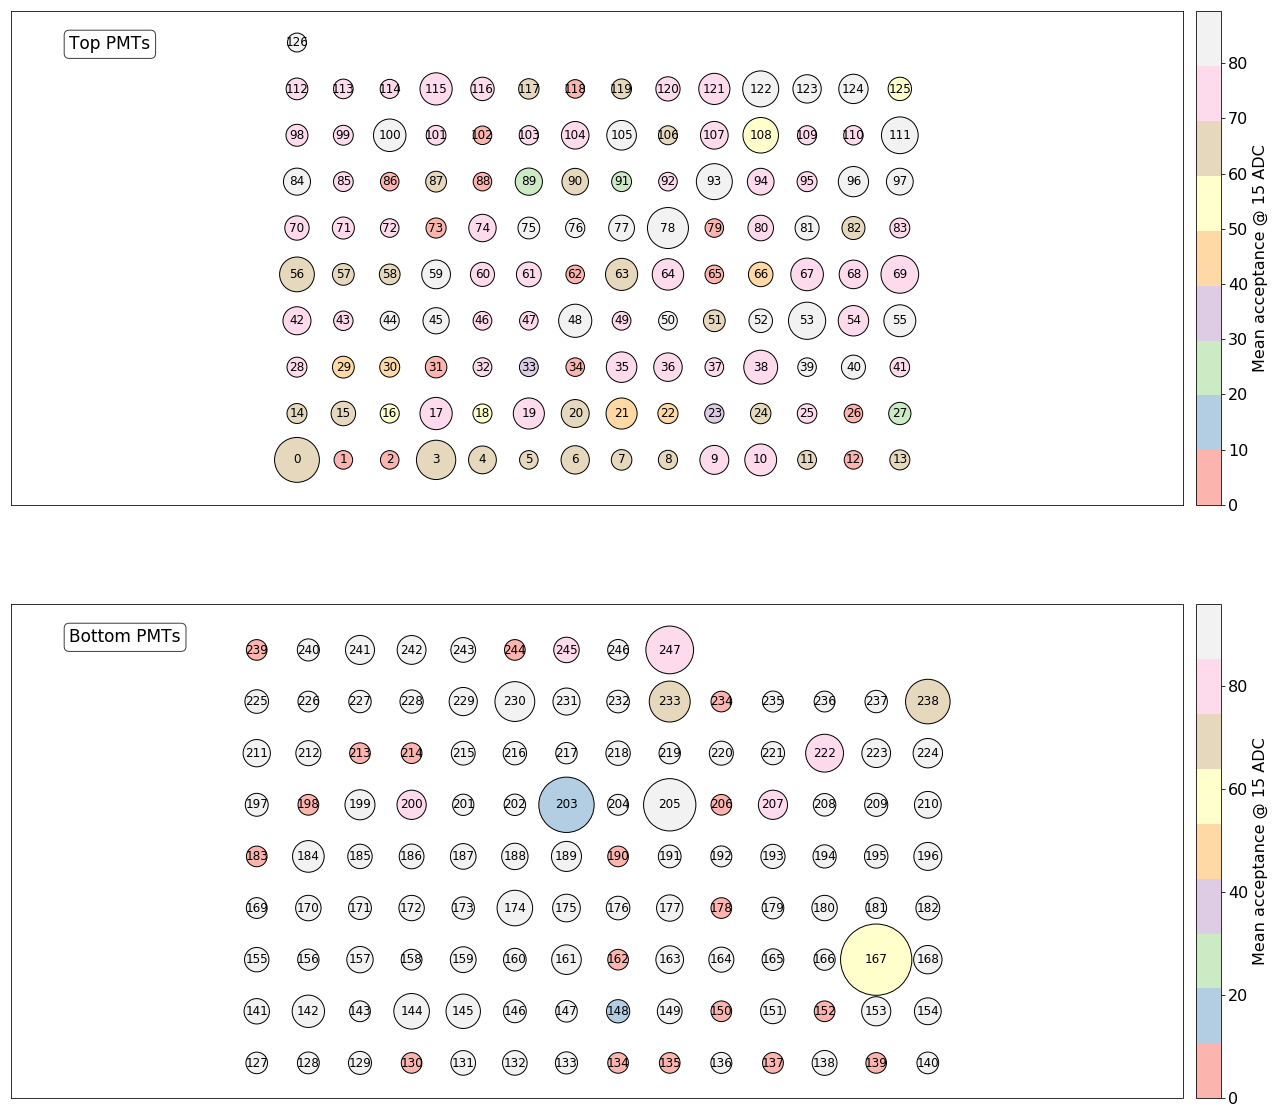

In [15]:
fig = plt.figure(figsize=(25,20))

plt.subplot(211)
patches = []
x = 1
y = 1
top = 127
for ch in range(0, top):
    circle = Circle((x,y), 1+5*std_acc[ch])
    patches.append(circle)
    plt.annotate(str(ch), xy=(x, y), fontsize=12, ha='center', va='center')
    x = x + 5
    if x>70:
        x = 1
        y = y + 5
    
p = PatchCollection(patches, cmap='Pastel1', alpha=1.0, edgecolor='black') # facecolor='none'
p.set_array(mean_acc[:top])
#qui plotta la luce che vedono
p.set_clim([min(mean_acc[:top]),max(mean_acc[:top])])

ax = plt.gca()
ax.add_collection(p)
plt.colorbar(p, ax=ax, pad=0.01, label="Mean acceptance @ 15 ADC")
ax.text(0.05, 0.95, "Top PMTs", transform=ax.transAxes, horizontalalignment='left',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75), fontsize=17)

plt.axis('equal')
plt.xticks([])
plt.yticks([])

plt.subplot(212)
patches = []
x = 1
y = 1
bot = 248
for ch in range(top, bot):
    circle = Circle((x,y), 1+5*std_acc[ch])
    patches.append(circle)
    plt.annotate(str(ch), xy=(x, y), fontsize=12, ha='center', va='center')
    x = x + 5
    if x>70:
        x = 1
        y = y + 5
    
p = PatchCollection(patches, cmap='Pastel1', alpha=1.0, edgecolor='black') # facecolor='none'
p.set_array(mean_acc[top:bot])
#qui plotta la luce che vedono
p.set_clim([min(mean_acc[top:bot]),max(mean_acc[top:bot])])

ax = plt.gca()
ax.add_collection(p)
plt.colorbar(p, ax=ax, pad=0.01, label="Mean acceptance @ 15 ADC")
ax.text(0.05, 0.95, "Bottom PMTs", transform=ax.transAxes, horizontalalignment='left',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75), fontsize=17)

plt.axis('equal')
plt.xticks([])
plt.yticks([])


plt.show()

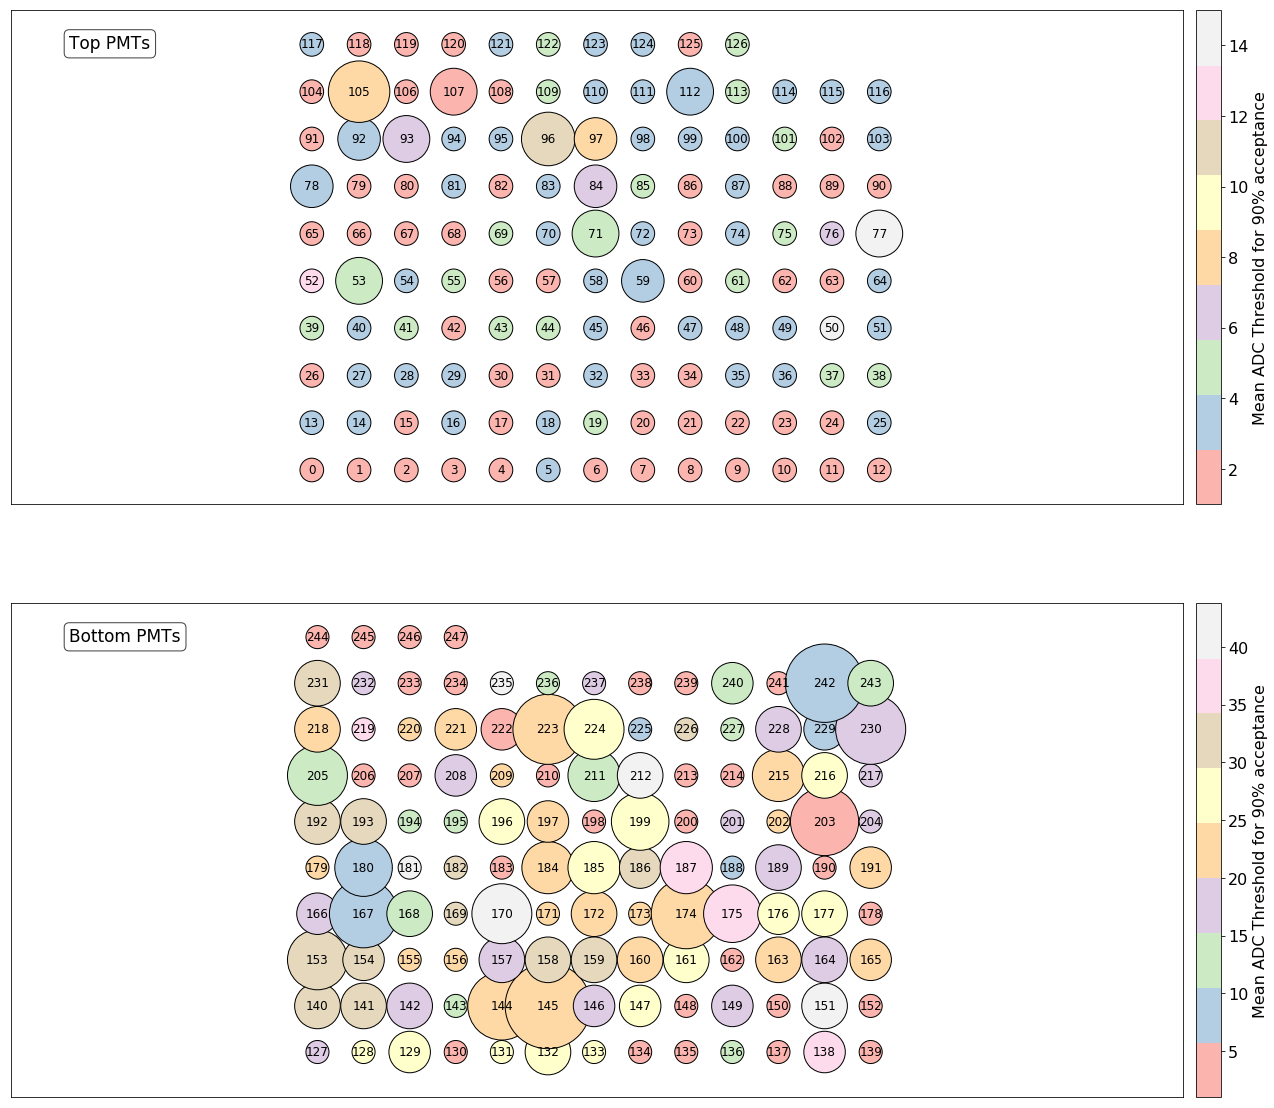

In [16]:
fig = plt.figure(figsize=(25,20))

plt.subplot(211)
patches = []
x = 1
y = 1
top = 127
for ch in range(0, top):
    circle = Circle((x,y), 1+5*std_thr[ch])
    patches.append(circle)
    plt.annotate(str(ch), xy=(x, y), fontsize=12, ha='center', va='center')
    x = x + 4
    if x>50:
        x = 1
        y = y + 4
    
p = PatchCollection(patches, cmap='Pastel1', alpha=1.0, edgecolor='black') # facecolor='none'
p.set_array(mean_thr[:top])
#qui plotta la luce che vedono
p.set_clim([min(mean_thr[:top]),max(mean_thr[:top])])

ax = plt.gca()
ax.add_collection(p)
plt.colorbar(p, ax=ax, pad=0.01, label="Mean ADC Threshold for 90% acceptance")
ax.text(0.05, 0.95, "Top PMTs", transform=ax.transAxes, horizontalalignment='left',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75), fontsize=17)

plt.axis('equal')
plt.xticks([])
plt.yticks([])

plt.subplot(212)
patches = []
x = 1
y = 1
bot = 248
for ch in range(top, bot):
    circle = Circle((x,y), 1+5*std_thr[ch])
    patches.append(circle)
    plt.annotate(str(ch), xy=(x, y), fontsize=12, ha='center', va='center')
    x = x + 4
    if x>50:
        x = 1
        y = y + 4
    
p = PatchCollection(patches, cmap='Pastel1', alpha=1.0, edgecolor='black') # facecolor='none'
p.set_array(mean_thr[top:bot])
#qui plotta la luce che vedono
p.set_clim([min(mean_thr[top:bot]),max(mean_thr[top:bot])])

ax = plt.gca()
ax.add_collection(p)
plt.colorbar(p, ax=ax, pad=0.01, label="Mean ADC Threshold for 90% acceptance")
ax.text(0.05, 0.95, "Bottom PMTs", transform=ax.transAxes, horizontalalignment='left',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75), fontsize=17)

plt.axis('equal')
plt.xticks([])
plt.yticks([])

plt.show()

### Single PMT watching

In [17]:
#######################################
## Which channel do you want to see? ##
#######################################
n_channel = 212

bins_correction = np.linspace(3,7,5)
acceptance = [SPE_acceptance[n_channel]['Acceptance @ 15 ADC '+str(j)+' bin']*100 for j in range(3,8)]
threshold  = [SPE_acceptance[n_channel]['Threshold for 0.9 acceptance '+str(j)+' bin'] for j in range(3,8)]

bin_correction_ = 7
mask = np.where(SPE_acceptance[SPE_acceptance['pmt']==n_channel]['SPE acceptance '+str(bin_correction_)+' bin'][0]<0.01)
x_max = SPE_acceptance[SPE_acceptance['pmt']==n_channel]['bins SPE acceptance '+str(bin_correction_)+' bin'][0][mask][0]

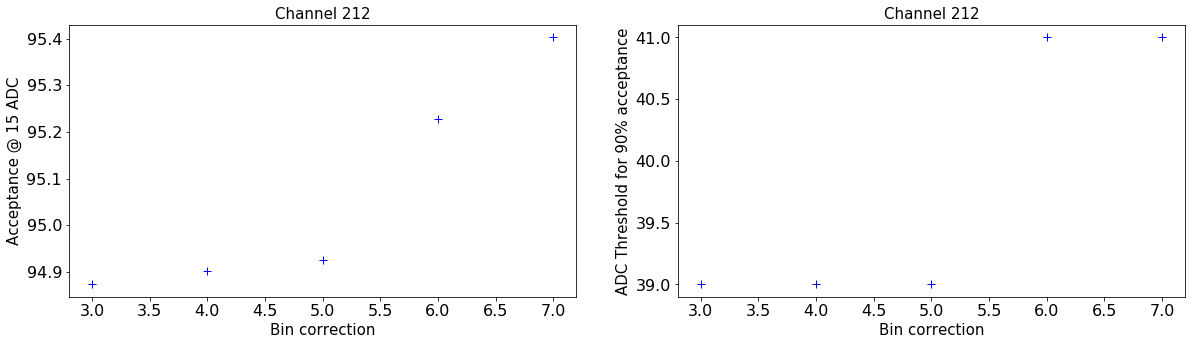

<Figure size 432x288 with 0 Axes>

In [18]:
fig = plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(bins_correction, acceptance, 'b+', ms=8)
#plt.xlim(left = 0)
plt.xlabel('Bin correction', fontsize=15)
plt.ylabel('Acceptance @ 15 ADC', fontsize=15)
plt.title('Channel %d' %n_channel, fontsize=15)
#plt.legend(loc='best', fontsize=17)

plt.subplot(122)
plt.plot(bins_correction, threshold, 'b+', ms=8)
#plt.xlim(left = 0)
plt.xlabel('Bin correction', fontsize=15)
plt.ylabel('ADC Threshold for 90% acceptance', fontsize=15)
plt.title('Channel %d' %n_channel, fontsize=15)
#plt.legend(loc='best', fontsize=17)

plt.show()
plt.tight_layout()

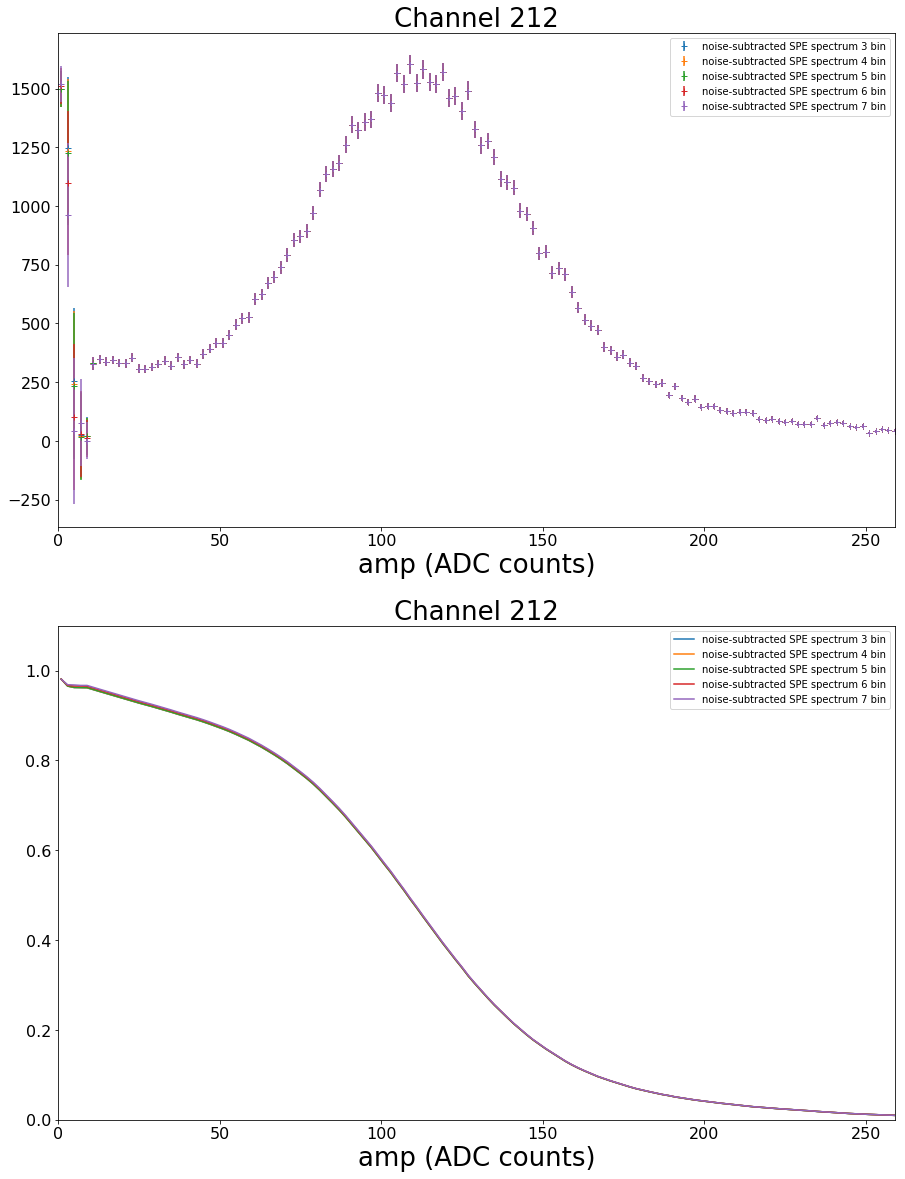

In [19]:
fig = plt.figure(figsize=(15,20))
plt.subplot(211)
for bin_correction in range(3,8):
    plt.errorbar(x = SPE_acceptance[SPE_acceptance['pmt']==n_channel]['bins SPE acceptance '+str(bin_correction)+' bin'][0], 
                 y = SPE_acceptance[SPE_acceptance['pmt']==n_channel]['noise-subtracted spectrum '+str(bin_correction)+' bin'][0], 
                 yerr = SPE_acceptance[SPE_acceptance['pmt']==n_channel]['error of noise-subtracted spectrum '+str(bin_correction)+' bin'][0], 
                 fmt='+', 
                 label='noise-subtracted SPE spectrum '+str(bin_correction)+' bin')

plt.xlim(0, x_max)
plt.xlabel('amp (ADC counts)', fontsize=26)
plt.title('Channel %d' %n_channel, fontsize=26)
plt.legend(loc='best', fontsize=10)

plt.subplot(212)

for bin_correction in range(3,8):
    plt.plot(SPE_acceptance[SPE_acceptance['pmt']==n_channel]['bins SPE acceptance '+str(bin_correction)+' bin'][0], 
             SPE_acceptance[SPE_acceptance['pmt']==n_channel]['SPE acceptance '+str(bin_correction)+' bin'][0],
             label='noise-subtracted SPE spectrum '+str(bin_correction)+' bin') 

plt.title('Acceptance', fontsize=26)
plt.ylim(0,1.1)
plt.xlim(0, x_max)
plt.xlabel('amp (ADC counts)', fontsize=26)
plt.title('Channel %d' %n_channel, fontsize=26)
plt.legend(loc='best', fontsize=10)

plt.show()

**The spectrum also contains contributions of 2 or more photoelectrons. From the scaling down factor of the noise s, 
assuming a Poisson distribution of photoelectrons we estimate that the average number of photoelectrons (occupancy) in the
spectrum occ = -ln(s). The fraction of events with 2 or more photoelectrons is then:** 

$P(n>2) = 1 - [P(n=0) + P(n=1)]$

**The contribution of 2 or more photoelectrons leads to a slight over-estimate in the acceptances.
While we have subtracted out the noise contribution to the amplitude when there are no photoelectrons, 
the noise also contributes to the amplitude when there is a photoelectron (the signal sits on top of the noise). 
This noise smears out the true SPE amplitude spectrum.**

3 0.06475877239590666
4 0.06499195494129317
5 0.06401802178388039
6 0.06353665786429019
7 0.06299953796406044


(0, 2000)

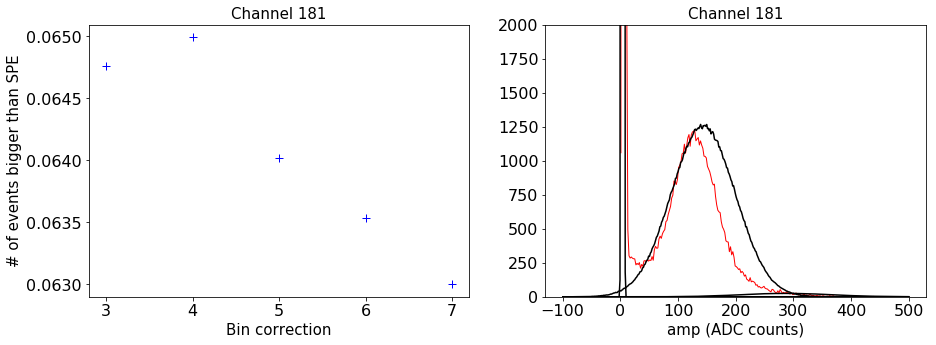

In [92]:
def fraction_no_SPE(occ):
    return 1 - np.exp(-occ)*(1+occ)

fraction = np.zeros(5)
for i in range(5):
    fraction[i] = fraction_no_SPE(SPE[SPE['pmt']==n_channel]['occupancy_'+str(i+3)+'bin'][0])
    print(i+3, fraction[i])
    
fig = plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(bins_correction, fraction, 'b+', ms=8)
plt.xlabel('Bin correction', fontsize=15)
plt.ylabel('# of events bigger than SPE', fontsize=15)
plt.title('Channel %d' %n_channel, fontsize=15)
#plt.xlim(left = 0)
#plt.legend(loc='best', fontsize=17)

plt.subplot(122)

N = sum(SPE[SPE['pmt']==n_channel]['spectrumLED'][0])*10
OPE_vals = sp.stats.norm.rvs(loc=info['noise_mu'][181], scale=info['noise_sigma'][181], size=N)
OPE_spectrum, OPE_bins = np.histogram(OPE_vals, bins=400, range=(-100.5, 500.5))
OPE_bins = 0.5 * (OPE_bins[1:] + OPE_bins[:-1])

SPE_vals = sp.stats.norm.rvs(loc=info['LED_mu'][181], scale=info['LED_sigma'][181], size=N)
SPE_spectrum, SPE_bins = np.histogram(SPE_vals, bins=400, range=(-100.5, 500.5))
SPE_bins = 0.5 * (SPE_bins[1:] + SPE_bins[:-1])

DPE_vals = sp.stats.norm.rvs(loc=2*info['LED_mu'][181], scale=np.sqrt(2)*info['LED_sigma'][181], size=N)
DPE_spectrum, DPE_bins = np.histogram(DPE_vals, bins=400, range=(-100.5, 500.5))
DPE_bins = 0.5 * (DPE_bins[1:] + DPE_bins[:-1])

TPE_vals = sp.stats.norm.rvs(loc=3*info['LED_mu'][181], scale=np.sqrt(3)*info['LED_sigma'][181], size=N)
TPE_spectrum, TPE_bins = np.histogram(TPE_vals, bins=400, range=(-100.5, 500.5))
TPE_bins = 0.5 * (TPE_bins[1:] + TPE_bins[:-1])

    
    

plt.plot(SPE[SPE['pmt']==n_channel]['bins_LED_center'][0], SPE[SPE['pmt']==n_channel]['spectrumLED'][0], 
         color='r', label='Amp LED', lw=1)

plt.plot(OPE_bins, OPE_spectrum*0.94, color='black')
plt.plot(SPE_bins, SPE_spectrum*0.06, color='black')
plt.plot(DPE_bins, DPE_spectrum*0.00169, color='black')
plt.plot(TPE_bins, TPE_spectrum*0.0000678, color='black')

plt.xlabel('amp (ADC counts)', fontsize=15)
plt.title('Channel %d' %n_channel, fontsize=15)
#plt.yscale('log')
#plt.legend(loc='best', fontsize=20)
plt.ylim(0, 2000)